# NMF Topic Models

Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply *matrix factorisation* methods, such as *Non-negative Matrix Factorisation (NMF)*. In this notebook we look at how to apply NMF using the *scikit-learn* library in Python.

In [1]:
import joblib
import numpy as np
from sklearn import decomposition
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

### Applying NMF

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [2]:
(A, terms, snippets) = joblib.load("articles-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 937 X 15 document-term matrix


The key input parameter to NMF is the number of topics to generate *k*. For the moment, we will pre-specify a guessed value, for demonstration purposes.

In [3]:
k = 10

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable results.

In [4]:
# create the model, specifiying the initialization strategy and the number of topics to produce
model = decomposition.NMF(init="nndsvd", n_components=k) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: *W* and *H*.

The *W* factor contains the document membership weights relative to each of the *k* topics. Each row corresponds to a single document, and each column correspond to a topic.

In [5]:
W.shape

(937, 10)

For instance, for the first document, we see that it is strongly associated with one topic. However,  each document can be potentially associated with multiple topics to different degrees.

In [6]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The *H* factor contains the term weights relative to each of the *k* topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [7]:
H.shape

(10, 15)

For instance, for the term "brexit", we see that it is strongly associated with a single topic. Again, in some cases each term can be associated with multiple topics.

In [10]:
term_index = terms.index('based')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.  , 0.08, 0.  , 0.01, 0.  , 0.1 , 0.  , 0.42, 0.11])

### Topic Descriptors

The top ranked terms from the *H* factor for each topic can give us an insight into the content of that topic. This is often called the *topic descriptor*. Let's define a function that extracts the descriptor for a specified topic: 

In [11]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

We can now get a descriptor for each topic using the top ranked terms (e.g. top 10):

In [12]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: disease, infectious, anatomical, classes, ontology, based, class, text, terms, system
Topic 02: ontology, labels, ontologies, disease, diseases, doid, system, text, terms, method
Topic 03: system, based, anatomical, diseases, disease, text, terms, ontology, ontologies, method
Topic 04: terms, anatomical, diseases, ontologies, labels, disease, text, system, ontology, method
Topic 05: classes, labels, ontologies, based, infectious, text, terms, system, ontology, method
Topic 06: class, labels, diseases, method, disease, doid, text, terms, system, ontology
Topic 07: doid, based, anatomical, disease, ontology, text, terms, system, ontologies, method
Topic 08: diseases, infectious, anatomical, classes, text, terms, system, ontology, ontologies, method
Topic 09: method, based, ontologies, anatomical, labels, diseases, text, terms, system, ontology
Topic 10: text, labels, based, diseases, terms, system, ontology, ontologies, method, infectious


The rankings above do not show the strength of association for the different terms. We can represent the distribution of the weights for the top terms in a topic using a *matplotlib* horizontal bar chart.

Define a function to create a bar chart for the specified topic, based on the *H* factor from the current NMF model:

In [13]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

So for instance, for the 7th topic we can generate a plot with the top 15 terms using:

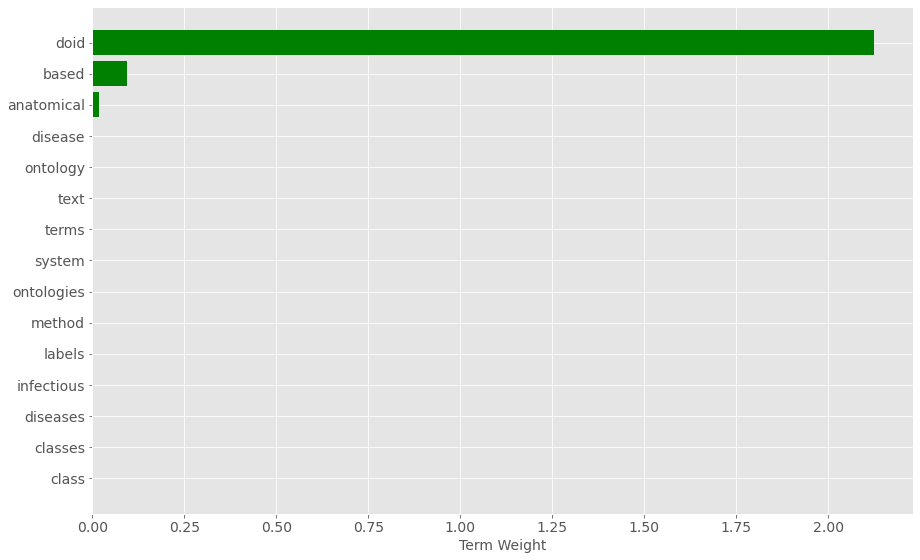

In [14]:
plot_top_term_weights(terms, H, 6, 15)

Similarly, the top 15 terms for the 4th topic in our model:

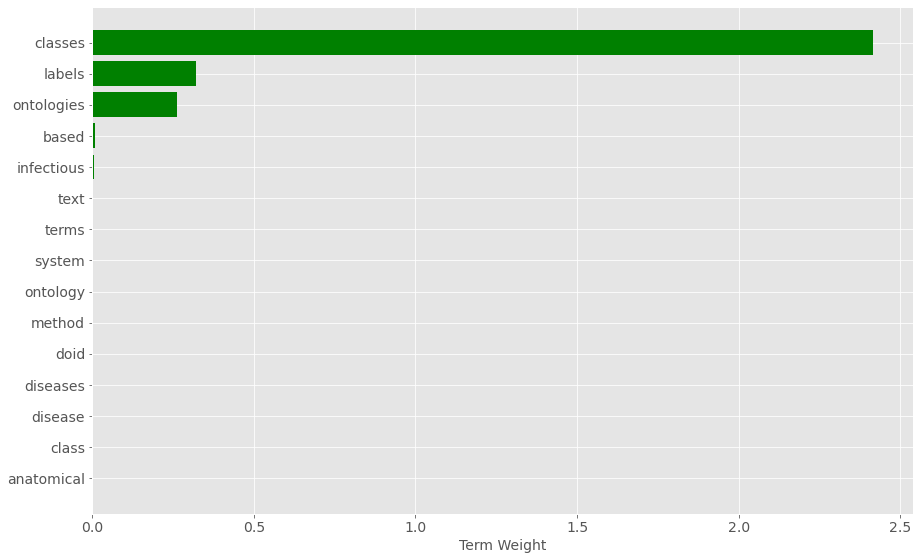

In [15]:
plot_top_term_weights(terms, H, 4, 15)

### Most Relevant Documents

We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [16]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

For instance, for the first topic listed above, the top 10 documents are:

In [17]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. disease
02. guish between them. While a disease is defined as the
03. Amyloidosis disease of
04. tem disease
05. and may be a part of a disease manifestation. Phenotype
06. tional results that might be related to that disease. Some
07. disease
08. disease
09. disease
10. view, it could be a type of disease under the umbrella


Similarly, for the second topic:

In [18]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. within a domain ontology (and therefore expected to refer
02. the Whatizit tool [20] to identify the mention of ontology
03. dencies within an ontology further determine whether a
04. Human Phenotype Ontology (HP) (HP:0004804) and
05. for generating and annotating a large number of ontology
06. logical axioms that may be added to an ontology. Recently,
07. in an ontology.
08. Ontology
09. Ontology Language (OWL) [26] format and extract a list
10. ontology development and extension.


### Exporting the Results

If we want to keep this topic model for later user, we can save it using *joblib*:

In [19]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k10.pkl']